# 1. Embedding

<img src="https://nlpinkorean.github.io/images/transformer/transformer_positional_encoding_vectors.png" width="50%" align="center">

- 트랜스포머의 입력에서 제일 처음 거치는 Embedding 부분
- 위 그림처럼, 모델에 입력되는 최종 embedding은 다음의 2가지 embedding을 더하는 방식으로 만들어짐
    - Input Embedding: 단어를 벡터로 표현하는 embedding
    - Positional Embedding: 문장에 각 단어의 순서를 알려주는 embedding

In [11]:
import torch
import torch.nn as nn

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# 8개의 단어로 이루어진 2개의 문장이 있다고 가정
# inp = torch.tensor(
#     [[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
#      [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]], dtype=torch.long)
# print(inp.shape)

# 64개의 단어로 이루어진 2개의 문장이 있다고 가정
inp = torch.randint(10000, (2, 64)).type(torch.long)
print(inp.shape)

torch.Size([2, 64])


## 1.1 Input Embedding

- 일반적으로 사용하는 `torch.nn.Embedding`을 통해 구현
  
![input](image/inputembedding.png)
  

In [12]:
# 단어사전 크기
n_vocab = 10000

# Embedding vector의 차원
d_model = 512

inp_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)

inp_embedding = inp_embed_layer(inp)
print(inp_embedding.size())

torch.Size([2, 64, 512])


## 1.2 Positional Encoding

$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{\text{model}}})$$
$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{\text{model}}})$$


- 논문에 나온 위의 2개 식에 따라 값을 구한다.
- $d_{model}$ : embedding vector의 차원
- $i$ : embedding에서 dimension 위치를 나타내며, 짝수($2i$)에는 sin 값을 계산하고 홀수($2i + 1$)에는 cos값을 계산한다.
    - $d_{model}$이 512라면 $i$는 0~255사이의 값이 되고, 각각 sin, cos를 구해 총 512개의 값을 구할 수 있다.
- $pos$ : sequence에 있는 각 word의 위치
- [참고 링크](https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model)의 vote많은 2번째 답변 참고하기

![input](image/position.png)


In [13]:
import numpy as np

# Positional encoding을 가져오는 함수
def get_pos_encoding(len_seq, d_model):
    # 결과를 담을 행렬 생성
    result_mat = np.zeros((len_seq, d_model))

    # pos와 나눌 분모 값 계산
    angle_div = [np.power(10000, ((2 * i) / d_model)) for i in range(d_model // 2)]

    # pos를 iterate하며 sine, cosine 값 계산
    for pos in range(len_seq):
        pe_sin = [np.sin(pos / div) for div in angle_div]
        pe_cos = [np.cos(pos / div) for div in angle_div]

        # 결과 행렬에 저장
        result_mat[pos, 0::2] = pe_sin # 0, 2, 4, ... (짝수)
        result_mat[pos, 1::2] = pe_cos # 1, 3, 5, ... (홀수)
    
    return result_mat

(64, 512)


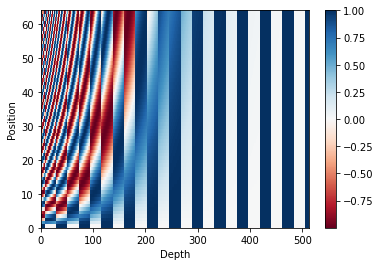

In [14]:
import matplotlib.pyplot as plt

# 한 문장이 64개의 단어로 이루어지고, 각 단어는 512 차원의 임베딩벡터로 이루어질 경우 (논문의 예)
mat = get_pos_encoding(len_seq=64, d_model=512)
print(mat.shape)

plt.pcolormesh(mat, cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

(8, 512)


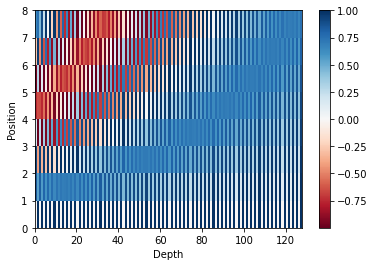

In [15]:
# 여기서 예시로 간단히 사용한 8개의 단어로 이루어지고, 각 단어는 512 차원의 임베딩벡터로 이루어질 경우
mat = get_pos_encoding(len_seq=8, d_model=512)
print(mat.shape)

plt.pcolormesh(mat, cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

## 1.3 Input Embedding + Positional Encoding

- 앞서 구한 input embedding과 positional encoding 값을 더해서 모델에 입력으로 들어갈 벡터를 생성

![inputplus.png](image/inputplus.png)

In [18]:
# 먼저, positional encoding을 계산
pos_encoding = get_pos_encoding(64, 128)
pos_encoding = torch.FloatTensor(pos_encoding)
print(pos_encoding.size())

torch.Size([64, 128])


In [19]:
# 앞서 구한 positional encoding으로 embedidng layer를 초기화하고 freeze
pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

# pos_embed_layer에서 값을 꺼내오기 위한 position sequence 생성
positions = torch.arange(inp.size(1)).expand(inp.size(0), inp.size(1))
print(positions)

# input embedding과 더해줄 positional embedding 생성
pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63]])
torch.Size([2, 64, 128])


### 총정리 : 입력에서 input emb + positional emb = final emb까지

In [20]:
# inp = torch.LongTensor(
#     [[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
#      [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
# print(inp.size())

In [21]:
n_vocab = 10000
d_model = 512
max_len_seq = inp.size(1) # 8

inp_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)
pos_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(get_pos_encoding(max_len_seq, d_model)),
                                               freeze=True)

print(inp_embed_layer)
print(pos_embed_layer)
print(pos_embed_layer.weight.requires_grad)

Embedding(10000, 512, padding_idx=0)
Embedding(64, 512)
False


In [22]:
inp_embedding = inp_embed_layer(inp)
print(inp_embedding.size())

torch.Size([2, 64, 512])


In [23]:
positions = torch.arange(inp.size(1)).expand(inp.size(0), inp.size(1))
pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

torch.Size([2, 64, 512])


In [24]:
final_embedding = inp_embedding + pos_embedding
print(final_embedding.shape)

torch.Size([2, 64, 512])


# 2. Multi-head Attention

<img src="https://nlpinkorean.github.io/images/transformer/self-attention-matrix-calculation.png" width="30%">

<img src="https://nlpinkorean.github.io/images/transformer/self-attention-matrix-calculation-2.png" width="30%">

<img src="https://paul-hyun.github.io/assets/2019-12-19/scale_dot_product_attention.png" width="50%">

- 트랜스포머의 self-attention에서 사용되는 어텐션 연산
- Self attention이므로, X가 모두 동일

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        
        # attention head 갯수
        self.n_head = n_head

        # 각 head당 차원
        self.d_head = d_model // n_head

        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense   = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V):

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # Q, K, V 생성
        # (batch_size, 문장 길이, num_heads * d_head)
        Q = self.query_dense(Q)
        K = self.key_dense(K)
        V = self.value_dense(V)

        # 2. 헤드 나누기
        # Q, K, V를 각 attention head로 분리
        # (batch_size, num_head, 문장 길이, d_model/num_heads)
        Q = Q.view(Q.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)

        # 3. 스케일드 닷 프로덕트 어텐션. 
        Z = torch.matmul(Q, K.permute(0, 1, 3, 2)) / torch.sqrt(torch.FloatTensor([self.d_head]))
        Z = torch.matmul(self.softmax(Z), V)

        # (batch_size, 문장 길이, num_heads, d_model/num_heads = d_head)
        Z = Z.permute(0, 2, 1, 3).contiguous()

        # 4. 헤드 연결하기
        # (batch_size, 문장 길이, num_heads * d_head)
        Z = Z.view(Z.size(0), -1, self.d_head * self.n_head)

        out = self.linear(Z)

        return out

In [14]:
# 앞에서 계산한 최종 임베딩이 입력이라고 가정
X = final_embedding
print(X.size())

att = MultiHeadAttention(d_model=512, n_head=8)
out = att(X, X, X)
print(out.size())

torch.Size([2, 64, 512])
torch.Size([2, 64, 512])
